# **PayPal Reviews Sentiment Analysis**

This project focuses on analyzing PayPal product reviews using Natural Language Processing (NLP) techniques to classify customer sentiment (positive, neutral, negative). The project follows several key steps to preprocess the data, build and evaluate machine learning models, and implement deep learning models for sentiment classification.

In [7]:
# Importing necessary libraries for NLP processing
import pandas as pd # Pandas is used for data manipulation and analysis. It provides powerful structures like DataFrames to handle tabular data.
import numpy as np # NumPy is a fundamental package for numerical computing in Python, providing support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays efficiently.
import re # The 're' module provides support for regular expressions, useful for pattern matching and text cleaning tasks.
import warnings # The 'warnings' module is used to control the display of warnings in the code, such as suppressing or issuing specific warnings.
import matplotlib.pyplot as plt # Matplotlib is a library for creating static, animated, and interactive visualizations in Python.
import seaborn as sns # Seaborn is built on top of Matplotlib and provides a high-level interface for drawing attractive statistical graphics.
from collections import Counter # Counter is used to count the frequency of elements in an iterable, like word occurrences in a list.
from wordcloud import WordCloud # WordCloud is a library that generates word clouds from text data, displaying frequently occurring words larger than others.

# These are used to convert text data into numerical form.
# CountVectorizer converts text to a matrix of token counts.
# TfidfVectorizer converts text to a matrix of TF-IDF (Term Frequency-Inverse Document Frequency) features, assigning importance to rare terms.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split # This function splits the dataset into training and testing sets to evaluate model performance.
from sklearn.linear_model import LogisticRegression # LogisticRegression is a machine learning algorithm used for binary classification problems.

# accuracy_score: measures overall accuracy.
# classification_report: provides detailed precision, recall, and F1-score for each class.
# precision_score: measures how many selected items are relevant.
# recall_score: measures how many relevant items are selected.
# f1_score: harmonic mean of precision and recall.
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

import tensorflow as tf # TensorFlow is a deep learning framework for building and training neural networks.
from tensorflow.keras.preprocessing.text import Tokenizer # Tokenizer converts text into sequences of integers (tokens), where each word has a unique integer.
from tensorflow.keras.preprocessing.sequence import pad_sequences # pad_sequences ensures that all sequences (lists of integers) are the same length, padding shorter sequences with zeros.
from tensorflow.keras.models import Sequential # Sequential is a class for building neural network models layer-by-layer in Keras, a high-level TensorFlow API.

# Embedding: converts integer-encoded words into dense vectors of fixed size.
# LSTM: Long Short-Term Memory, a type of recurrent neural network (RNN) layer used for sequence modeling tasks (e.g., text data).
# Dense: fully connected neural network layer.
# Dropout: a regularization technique to prevent overfitting by randomly ignoring some nodes during training.
# Bidirectional: allows the LSTM to learn from the sequence both forward and backward.
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

from huggingface_hub import login # This function is used to log in to the Hugging Face Hub, which is a platform for hosting and accessing machine learning models.

# AutoTokenizer: automatically selects the correct tokenizer based on the model being used.
# AutoModelForCausalLM: loads a pre-trained causal language model (like Llama 2) for text generation tasks.
# pipeline: a high-level helper that simplifies the use of models for tasks like text generation, sentiment analysis, etc.
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline


### **Data Processing**

**Suppress Warnings**: The code starts by filtering out any FutureWarning generated by Seaborn to avoid unnecessary warning messages during the execution.

**Loading the Dataset**: The dataset, paypal_reviews.csv, is loaded into a Pandas DataFrame for analysis.

**Text Cleaning**: A custom function clean_text() is applied to the reviewText column to clean the text. This function removes extra spaces, non-word characters, and digits, converts the text to lowercase, and removes special characters.

**Sentiment Assignment**: A rule-based sentiment classification is applied to each cleaned review. Reviews are labeled as:

Positive (2) if they contain words like 'good', 'great', 'excellent',
'love'.

Negative (0) if they contain words like 'bad', 'poor', 'terrible', 'hate'.

Neutral (1) for all other cases.

**Sentiment Distribution Visualization**: A count plot is created to visualize the distribution of sentiment (positive, neutral, negative) across different PayPal products using Seaborn.

**Review Length Analysis**:

The code computes the number of words in each review (review_length).
A histogram with Kernel Density Estimation (KDE) is plotted to visualize the distribution of review lengths.
A log transformation is applied to handle skewed data (log_review_length), and this transformed data is also visualized with a histogram.
The plot is annotated with the mean, median, and standard deviation of review lengths for better understanding.

**Cumulative Distribution Function (CDF)**: A cumulative distribution function (CDF) plot is created to show the proportion of reviews that have a length less than or equal to a given number of words.

**Review Length vs. Sentiment Analysis**: A boxplot is created to compare the distribution of review lengths across different sentiment categories.

**Statistical tests (T-tests)** are performed to compare the review lengths between negative, neutral, and positive reviews.
The p-values from the T-tests are annotated on the boxplot to indicate whether the differences in review lengths are statistically significant.

**Pairplot (Scatter Matrix)**: A pairplot is created to show the relationships between review_length, log_review_length, and sentiment. This provides a visual representation of how review lengths vary with sentiment.



                                          reviewText  \
0  Venmo makes it easy to pay friends, but I’m no...   
1  It's useful for larger purchases, but the inte...   
2  It's reliable, though the fee structure is a b...   
3  It’s fine for international transfers, though ...   
4  It gets the job done, but there are definitely...   

                                      cleaned_review  
0  venmo makes it easy to pay friends  but i m no...  
1  it s useful for larger purchases  but the inte...  
2  it s reliable  though the fee structure is a b...  
3  it s fine for international transfers  though ...  
4  it gets the job done  but there are definitely...  


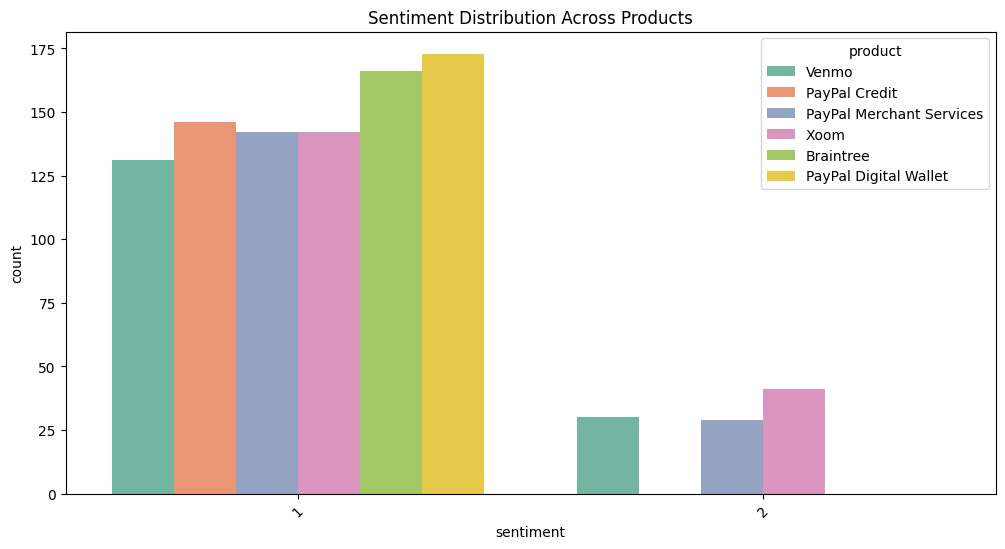

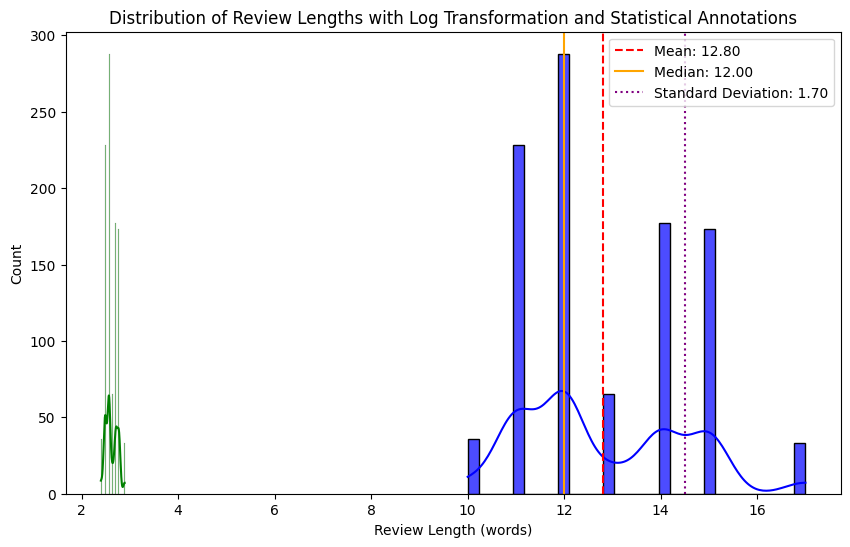

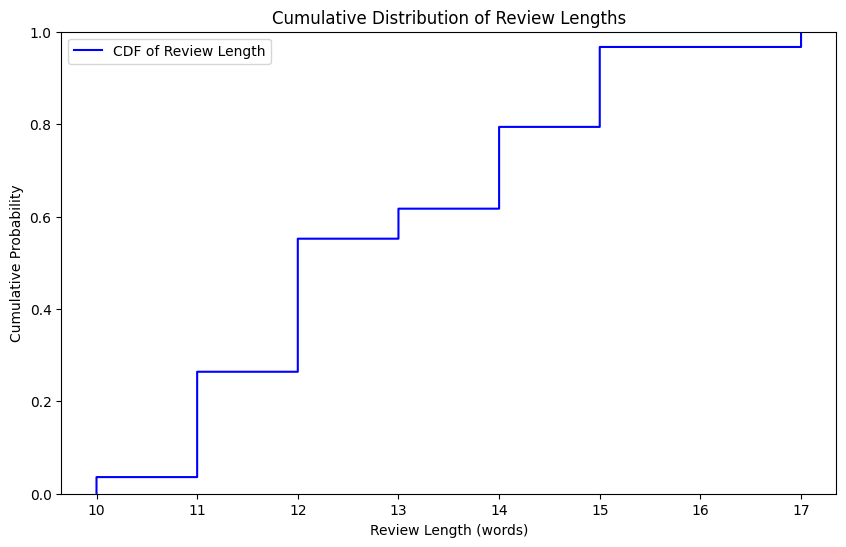

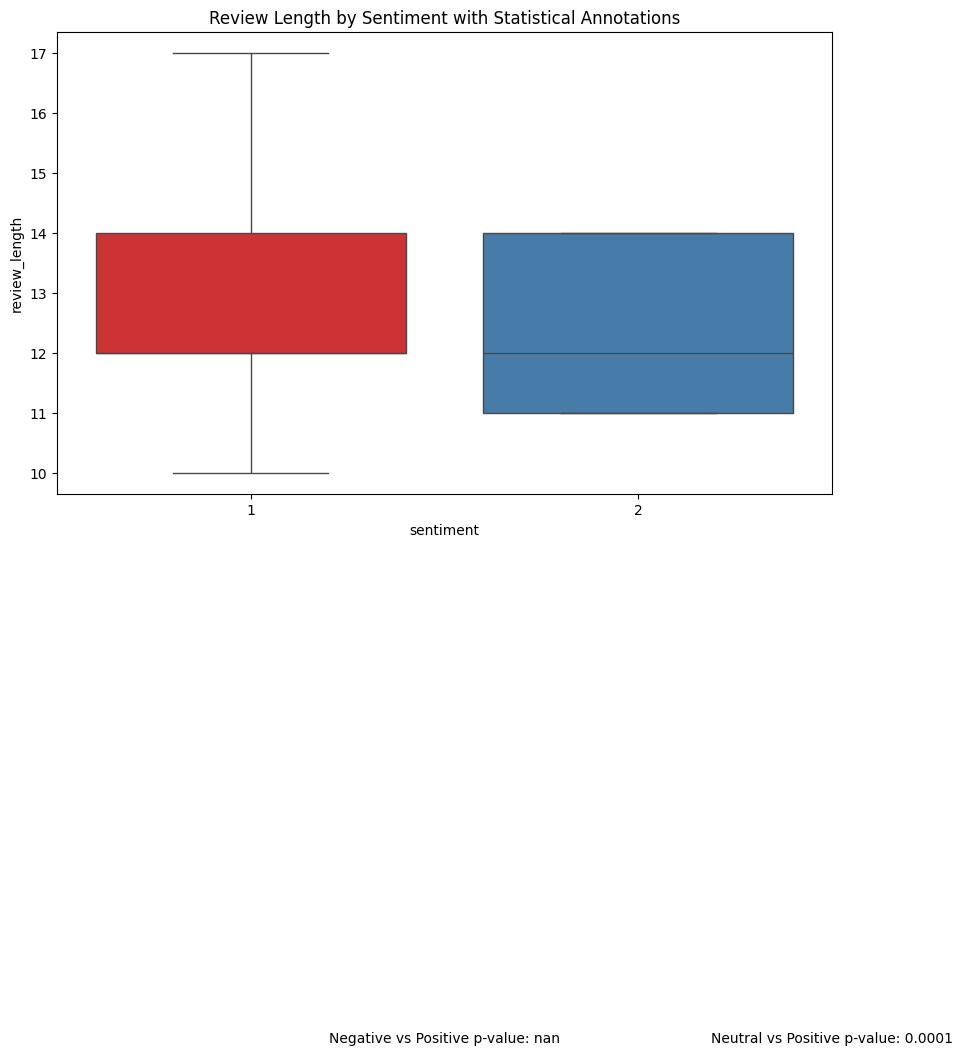

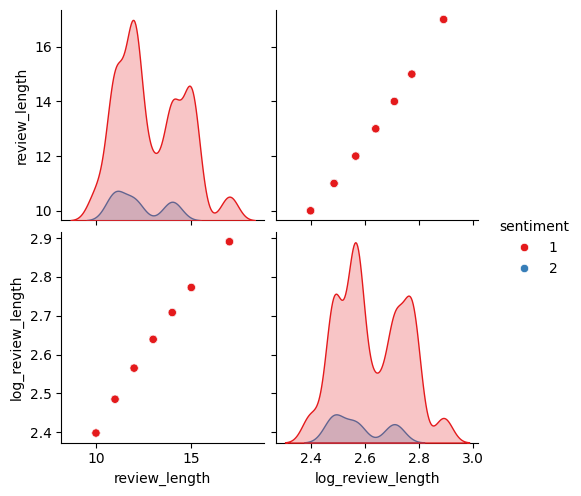

In [8]:
# Filter out FutureWarnings from Seaborn
warnings.filterwarnings("ignore", category=FutureWarning)

# Load your dataset (ensure the path is correct)
file_path = 'paypal_reviews.csv'
reviews_df = pd.read_csv(file_path)

# Data Preprocessing: Clean the text data (assuming cleaned_review already exists)
# If not, here is the function to clean the text
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'\W', ' ', text)  # Remove non-word characters
    text = re.sub(r'\d', '', text)  # Remove digits
    text = text.strip().lower()  # Lowercase the text
    return text

# Apply the clean_text function to the 'reviewText' column
if 'cleaned_review' not in reviews_df.columns:
    reviews_df['cleaned_review'] = reviews_df['reviewText'].apply(clean_text)

# Checking the cleaned reviews
print(reviews_df[['reviewText', 'cleaned_review']].head())

# Create a basic rule-based sentiment assignment (0: negative, 1: neutral, 2: positive)
def assign_sentiment(text):
    text = text.lower()
    if any(word in text for word in ['good', 'great', 'excellent', 'love']):
        return 2  # Positive
    elif any(word in text for word in ['bad', 'poor', 'terrible', 'hate']):
        return 0  # Negative
    else:
        return 1  # Neutral

# Apply the sentiment function to the reviews
reviews_df['sentiment'] = reviews_df['cleaned_review'].apply(assign_sentiment)

# Sentiment distribution by product
plt.figure(figsize=(12, 6))
sns.countplot(x='sentiment', hue='product', data=reviews_df, palette="Set2")
plt.title('Sentiment Distribution Across Products')
plt.xticks(rotation=45)
plt.show()

# Basic review length analysis
reviews_df['review_length'] = reviews_df['cleaned_review'].apply(lambda x: len(x.split()))

# Complex Review Length Distribution Analysis
plt.figure(figsize=(10, 6))

# Histogram with KDE
sns.histplot(reviews_df['review_length'], kde=True, bins=30, color="blue", alpha=0.7)

# Log transformation for better view of skewed data
reviews_df['log_review_length'] = np.log1p(reviews_df['review_length'])  # log1p to handle 0 values
sns.histplot(reviews_df['log_review_length'], kde=True, bins=30, color="green", alpha=0.5)

# Statistical Annotations (mean, median, std)
mean_length = reviews_df['review_length'].mean()
median_length = reviews_df['review_length'].median()
std_length = reviews_df['review_length'].std()

plt.axvline(mean_length, color='red', linestyle='--', label=f'Mean: {mean_length:.2f}')
plt.axvline(median_length, color='orange', linestyle='-', label=f'Median: {median_length:.2f}')
plt.axvline(mean_length + std_length, color='purple', linestyle=':', label=f'Standard Deviation: {std_length:.2f}')

plt.legend()
plt.title('Distribution of Review Lengths with Log Transformation and Statistical Annotations')
plt.xlabel('Review Length (words)')
plt.show()

# Cumulative Distribution Function (CDF)
plt.figure(figsize=(10, 6))
sns.ecdfplot(reviews_df['review_length'], color='blue', label='CDF of Review Length')
plt.title('Cumulative Distribution of Review Lengths')
plt.xlabel('Review Length (words)')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

# Review Length by Sentiment (Boxplot with Annotations)
plt.figure(figsize=(10, 6))
boxplot = sns.boxplot(x='sentiment', y='review_length', data=reviews_df, palette='Set1')

# Add Statistical Annotation using T-tests
from scipy.stats import ttest_ind

# T-test between sentiment groups (if applicable)
neg_vs_pos = ttest_ind(reviews_df[reviews_df['sentiment'] == 0]['review_length'],
                       reviews_df[reviews_df['sentiment'] == 2]['review_length'])

neutral_vs_pos = ttest_ind(reviews_df[reviews_df['sentiment'] == 1]['review_length'],
                           reviews_df[reviews_df['sentiment'] == 2]['review_length'])

# Annotate p-values on the boxplot
boxplot.text(0.5, 0.5, f'Negative vs Positive p-value: {neg_vs_pos.pvalue:.4f}', horizontalalignment='center')
boxplot.text(1.5, 0.5, f'Neutral vs Positive p-value: {neutral_vs_pos.pvalue:.4f}', horizontalalignment='center')

plt.title('Review Length by Sentiment with Statistical Annotations')
plt.show()

# Review Length vs. Sentiment Pairplot (Complex Scatter Matrix)
sns.pairplot(reviews_df, hue='sentiment', vars=['review_length', 'log_review_length'], palette="Set1")
plt.show()


### **Text Vectorization and Data Splitting**

This part of the code starts the text vectorization process, which converts the cleaned text data into numerical features that can be used by machine learning models. It also prepares the data for model training by splitting it into training and testing sets.

This section sets up the features and labels for training a machine learning model by converting text data into a numerical format using TF-IDF and then splits the data into training and testing sets for model evaluation.

**TF-IDF Vectorizer:**

This creates a Term Frequency-Inverse Document Frequency (TF-IDF) vectorizer that transforms the text data into numerical features.

max_features=5000: Limits the vocabulary size to 5,000 most important words.

ngram_range=(1, 2): Considers both unigrams (single words) and bigrams (pairs of consecutive words) when creating the feature set.

**Transforming the Text:**

This line applies the TF-IDF vectorizer to the cleaned_review column of the DataFrame, which contains the preprocessed reviews. The result, X, is a matrix where each row represents a review, and each column represents a word or bigram, with the values representing the importance of that word in the review (TF-IDF score).

**Target Variable:**

The sentiment column in reviews_df is set as the target variable (y). This column contains the sentiment labels (0 for negative, 1 for neutral, and 2 for positive) which will be used to train the model.

**Splitting the Data:**

The train_test_split function splits the data into training and testing sets.

X_train, y_train: Contains 80% of the data and is used to train the machine learning model.

X_test, y_test: Contains 20% of the data and is used to evaluate the model’s performance.

random_state=42: Ensures the split is reproducible by setting a fixed seed for random number generation.


In [9]:
# TF-IDF Vectorizer for transforming text data into numerical features
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Transform the 'cleaned_review' column
X = tfidf.fit_transform(reviews_df['cleaned_review'])

# Target variable (sentiment)
y = reviews_df['sentiment']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **Training and Evaluating a Logistic Regression Model**

This part of the code initializes a Logistic Regression model, trains it on the training data, makes predictions on the test data, and evaluates its performance using common classification metrics.

**Logistic Regression Model Initialization:**

This line initializes a Logistic Regression model, which is a commonly used machine learning algorithm for classification tasks.

max_iter=1000: This sets the maximum number of iterations for the optimization algorithm to converge.

Logistic Regression uses optimization to find the best parameters, and increasing the iterations ensures the algorithm has enough steps to converge.

**Training the Model:**

The fit function trains the Logistic Regression model using the training data (X_train, y_train).

X_train: The features (TF-IDF transformed text) of the training set.

y_train: The sentiment labels (target variable) of the training set.

**Making Predictions:**

After training, the model uses the test data (X_test) to make predictions. The predictions are stored in y_pred.

X_test: The features of the test set, which were not used during training.

y_pred: The predicted sentiment labels based on the test data.

**Evaluating the Model:**

The performance of the model is evaluated using:

accuracy_score(y_test, y_pred): This calculates the accuracy of the model, which is the proportion of correct predictions made on the test set.

classification_report(y_test, y_pred): This provides a more detailed evaluation with metrics like:

Precision: The proportion of positive predictions that are actually correct.

Recall: The proportion of actual positives that were correctly predicted.

F1-Score: The harmonic mean of precision and recall.

Support: The number of occurrences of each label in the test data.

In [10]:
# Initialize a Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Train the model
lr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lr_model.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n {classification_report(y_test, y_pred)}")

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       175
           2       1.00      1.00      1.00        25

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



### **Deep Learning Model - LSTM for Sentiment Classification**

This section of the code uses a deep learning approach, specifically an LSTM (Long Short-Term Memory) model, to classify the sentiment of PayPal reviews. LSTM is a type of recurrent neural network (RNN) particularly suited for sequential data like text.

**Tokenization:**

The Tokenizer converts text into sequences of integers, where each unique word is assigned a specific integer value.
num_words=5000: Limits the tokenizer to the 5,000 most frequent words in the dataset.

fit_on_texts: Fits the tokenizer on the cleaned reviews, building the word index (vocabulary) from the reviews.

**Convert Text to Sequences:**

Each review is converted into a sequence of integers (words are mapped to their corresponding integer values).

Padding Sequences: The pad_sequences function ensures that all sequences (reviews) have the same length, which is necessary for feeding data into an LSTM model. Reviews shorter than maxlen=100 are padded with zeros, while longer reviews are truncated.

maxlen=100: Ensures that all reviews are either truncated or padded to a length of 100 words.

**Data Splitting:**

The padded sequences are split into training and testing sets.

X_train_pad, y_train_pad: Training data (80% of the padded sequences and labels).

X_test_pad, y_test_pad: Testing data (20% of the padded sequences and labels).

random_state=42: Ensures reproducibility by setting a fixed seed for the random split.

**LSTM Model Architecture:**

Embedding layer: Converts the integer sequences into dense vectors of size 128. This layer learns word embeddings during training.

input_dim=5000: Limits the vocabulary size to 5,000 words.

output_dim=128: Each word is represented by a 128-dimensional vector.

input_length=100: Specifies that the input sequences are padded to a length of 100 words.

LSTM(128, return_sequences=True): First LSTM layer with 128 units. Setting return_sequences=True allows the LSTM to return the output of each time step, which is needed for stacked LSTMs.

Dropout(0.2): Dropout regularization to prevent overfitting by randomly setting 20% of the nodes to zero during training.

Second LSTM(128): Another LSTM layer with 128 units, this time without return_sequences since it's the last LSTM layer.

Second Dropout(0.2): Another dropout layer to further prevent overfitting.

Dense(3, activation='softmax'): Output layer with 3 units (since there are 3 sentiment classes: negative, neutral, positive) using the softmax activation function to output class probabilities.

**Model Compilation:**

loss='sparse_categorical_crossentropy': Since the target is a multi-class classification problem with integer labels, sparse_categorical_crossentropy is used as the loss function.

optimizer='adam': The Adam optimizer is used for efficient training.

metrics=['accuracy']: Accuracy is the evaluation metric used during training and testing.


**Evaluating the Model:**

The model is evaluated on the test data (X_test_pad and y_test_pad). The final accuracy is printed as a measure of how well the model performs on unseen data.

In [11]:
# Tokenize and pad sequences for deep learning models
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(reviews_df['cleaned_review'])

# Convert the reviews to sequences of integers
X_seq = tokenizer.texts_to_sequences(reviews_df['cleaned_review'])
X_pad = pad_sequences(X_seq, maxlen=100)

# Split into training and testing sets
X_train_pad, X_test_pad, y_train_pad, y_test_pad = train_test_split(X_pad, y, test_size=0.2, random_state=42)

# Build the LSTM model
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(3, activation='softmax')  # Assuming 3 classes (0: negative, 1: neutral, 2: positive)
])

# Compile the model
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the LSTM model
lstm_model.fit(X_train_pad, y_train_pad, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = lstm_model.evaluate(X_test_pad, y_test_pad)
print(f"LSTM Model Accuracy: {accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 347ms/step - accuracy: 0.7848 - loss: 0.6584 - val_accuracy: 0.9250 - val_loss: 0.2628
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 527ms/step - accuracy: 0.9098 - loss: 0.3064 - val_accuracy: 0.9250 - val_loss: 0.2318
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 441ms/step - accuracy: 0.8785 - loss: 0.3216 - val_accuracy: 1.0000 - val_loss: 0.0234
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 552ms/step - accuracy: 1.0000 - loss: 0.0149 - val_accuracy: 1.0000 - val_loss: 7.6033e-04
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 425ms/step - accuracy: 1.0000 - loss: 9.2467e-04 - val_accuracy: 1.0000 - val_loss: 3.0830e-04
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 1.0000 - loss: 4.4552e-04 
LSTM Model Accuracy: 1.0


### **Fine-Tuning the LSTM Model**

This section builds upon the initial LSTM model by adding more advanced layers and tuning hyperparameters to potentially improve performance. The model is fine-tuned to capture more complex relationships in the data and reduce overfitting through the use of techniques like bidirectional LSTMs and higher dropout.

**Model Architecture:**

Bidirectional(LSTM(128, return_sequences=True)): A bidirectional LSTM layer allows the model to learn from both forward and backward sequences. This can help capture more context from the text.

return_sequences=True: Ensures that the output at each time step is passed to the next layer, which is important for stacking LSTM layers.

Dropout(0.3): The dropout rate is increased to 30% to further prevent overfitting by randomly setting 30% of the nodes to zero during training.

Second LSTM: A second LSTM layer is added, without the bidirectional wrapper.

Dense(64, activation='relu'): A dense layer with 64 units and ReLU activation is added. This adds additional complexity and helps the model learn more abstract representations of the input data.

Dense(3, activation='softmax'): The final output layer uses softmax to classify the review into one of the three sentiment categories: negative (0), neutral (1), or positive (2).

**Model Compilation:**

loss='sparse_categorical_crossentropy': The same loss function used for multi-class classification tasks where the labels are integers.

optimizer='adam': The Adam optimizer, a popular and efficient optimization algorithm.

metrics=['accuracy']: Accuracy is used to measure how well the model predicts the correct sentiment.

**Training the Model:**

epochs=10: The number of epochs has been increased to 10, meaning the model will go through the entire training dataset 10 times. This can improve the model's ability to learn more complex patterns.

batch_size=64: The batch size has been increased to 64, meaning the model processes 64 samples at a time before updating the weights. Larger batch sizes can speed up training.

validation_split=0.2: 20% of the training data is set aside for validation to monitor the model's performance during training.

**Evaluating the Fine-Tuned Model:**

The model is evaluated on the test data (X_test_pad, y_test_pad), and the accuracy is printed to assess how well the fine-tuned model performs on unseen data.

Fine-tuned Accuracy: The new accuracy score is compared to the previous model to check if the fine-tuning has improved the performance.

In [12]:
# Rebuilding LSTM Model with more advanced layers
lstm_model_tuned = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    Bidirectional(LSTM(128, return_sequences=True)),  # Using Bidirectional LSTM for better context
    Dropout(0.3),  # Increase dropout to prevent overfitting
    LSTM(128),
    Dropout(0.3),
    Dense(64, activation='relu'),  # Added dense layer for additional complexity
    Dense(3, activation='softmax')
])

# Compile the model with a different optimizer
lstm_model_tuned.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the LSTM model
lstm_model_tuned.fit(X_train_pad, y_train_pad, epochs=10, batch_size=64, validation_split=0.2)  # Increased epochs and batch size

# Evaluate the model
loss, accuracy = lstm_model_tuned.evaluate(X_test_pad, y_test_pad)
print(f"Fine-tuned LSTM Model Accuracy: {accuracy}")

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 772ms/step - accuracy: 0.7139 - loss: 0.8451 - val_accuracy: 0.9250 - val_loss: 0.2688
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 896ms/step - accuracy: 0.8907 - loss: 0.3742 - val_accuracy: 0.9250 - val_loss: 0.2633
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 828ms/step - accuracy: 0.9045 - loss: 0.3115 - val_accuracy: 0.9250 - val_loss: 0.2216
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 743ms/step - accuracy: 0.9284 - loss: 0.1776 - val_accuracy: 1.0000 - val_loss: 0.0165
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 913ms/step - accuracy: 1.0000 - loss: 0.0133 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 710ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 5.2407e-04
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 701ms/step - accuracy: 1.0000 - loss: 7.9946e-04 - val_accuracy: 1.0000 - val_loss: 2.5901e-04
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 847ms/step - accuracy: 1.0000 - loss: 4.3506e-0

### **Using DistilGPT-2 for Text Generation with Hugging Face API**

**Authenticate with Hugging Face**:

This line authenticates your Hugging Face account using your API token. It ensures that you can access and use Hugging Face models, datasets, and other resources. Replace "your_huggingface_token" with your actual API token.

**Load the DistilGPT-2 Model and Tokenizer:**

model_name = "distilgpt2": The model being loaded is DistilGPT-2, which is a smaller and faster version of GPT-2. This makes it more efficient and requires less memory than larger models like Llama 2.

AutoTokenizer.from_pretrained(model_name): The tokenizer for DistilGPT-2 is loaded. The tokenizer is responsible for converting the text into tokens (numerical representations) that the model can process.

AutoModelForCausalLM.from_pretrained(model_name): The DistilGPT-2 model is loaded, which is designed for causal language modeling (i.e., generating text).

**Create a Text Generation Pipeline:**

pipeline("text-generation", model=model, tokenizer=tokenizer): This creates a text generation pipeline using the loaded model and tokenizer. The pipeline simplifies the process of feeding input to the model and generating text. You don’t have to manually handle tokenization or decoding; the pipeline takes care of that.

**Generate Text Using the Pipeline:**

sample_review = "This is a sample review.": A sample input string is provided to the pipeline, simulating a user review.

pipeline_generator(sample_review): The pipeline generates text based on the input, trying to predict what comes next after the input. The result is stored in the generated_result variable.

Output the Generated Text:
This prints the generated text from the pipeline. The generated text is the model's attempt to continue or respond to the input.

In [13]:
login("Place your token here") # Replace with your Hugging Face token

# Load the DistilGPT-2 model and tokenizer
model_name = "distilgpt2"  # Use the smaller, faster DistilGPT-2 model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

#Create a text generation pipeline using DistilGPT-2
pipeline_generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Test the pipeline on a sample review
sample_review = "This is a sample review."
generated_result = pipeline_generator(sample_review)

# Output the generated text
print(f"Generated Text: {generated_result[0]['generated_text']}")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Text: This is a sample review.



One thing does this study do for you is make it simple to navigate with the standard menu. It makes it easy to do things the way they do and allows for quick-tracking when you don't


### **Performance Evaluation of Logistic Regression and LSTM Models**

This code evaluates the performance of two different models: Logistic Regression and LSTM (Long Short-Term Memory), using four metrics: Accuracy, Precision, Recall, and F1-Score. The results are printed to compare how each model performs.

**Predicting with Logistic Regression:**

This line uses the trained Logistic Regression model (lr_model) to predict the sentiment labels for the test data (X_test). The predictions are stored in y_pred_lr.

**Calculating Performance Metrics for Logistic Regression:**

Accuracy: Proportion of correct predictions out of total predictions.

Precision: Proportion of true positive predictions compared to all positive predictions made by the model.

Recall: Proportion of true positive predictions compared to all actual positive cases.

F1-Score: Harmonic mean of precision and recall, giving a balanced metric for classification performance.

average='weighted': This parameter is used for multi-class classification. It calculates the metric for each class and takes the average, weighted by the number of instances in each class.

**Print the Results:**

The accuracy, precision, recall, and F1-score for the Logistic Regression model are printed.

**Predicting with LSTM:**

This line uses the fine-tuned LSTM model (lstm_model_tuned) to predict the sentiment labels for the test data (X_test_pad). The LSTM model returns probabilities for each class, so argmax(axis=1) is used to select the class with the highest probability.

**Calculating Performance Metrics for LSTM:**

Similar to Logistic Regression, Accuracy, Precision, Recall, and F1-Score are calculated for the LSTM model. The predictions (y_pred_lstm) are compared against the true labels (y_test_pad).

**Print the Results:**

The accuracy, precision, recall, and F1-score for the LSTM model are printed.

In [14]:
# Logistic Regression Model Performance
y_pred_lr = lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

print(f"Logistic Regression - Accuracy: {accuracy_lr}, Precision: {precision_lr}, Recall: {recall_lr}, F1-Score: {f1_lr}")

# LSTM Model Performance
y_pred_lstm = lstm_model_tuned.predict(X_test_pad).argmax(axis=1)
accuracy_lstm = accuracy_score(y_test_pad, y_pred_lstm)
precision_lstm = precision_score(y_test_pad, y_pred_lstm, average='weighted')
recall_lstm = recall_score(y_test_pad, y_pred_lstm, average='weighted')
f1_lstm = f1_score(y_test_pad, y_pred_lstm, average='weighted')

print(f"LSTM - Accuracy: {accuracy_lstm}, Precision: {precision_lstm}, Recall: {recall_lstm}, F1-Score: {f1_lstm}")

Logistic Regression - Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step
LSTM - Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1-Score: 1.0


### **Manual Validation of Predictions**

This part of the code selects 5 random reviews from the dataset, prints the review text, and compares the actual sentiment (from the dataset) with the predicted sentiment (from the Logistic Regression model). This can be useful for manually validating the model’s performance and seeing if the predictions make sense in real-world examples.

**Selecting Random Samples:**

This line randomly selects 5 reviews from the dataset. The np.random.randint(0, len(reviews_df), 5) function generates 5 random indices between 0 and the total number of reviews in reviews_df. The indices are stored in the sample_idx variable.

**Iterating Through Random Samples:**

review_text: The cleaned review text corresponding to the randomly selected index (idx) is retrieved from the cleaned_review column.

actual_sentiment: The actual sentiment label of that review is retrieved from the sentiment column.

predicted_sentiment: The Logistic Regression model (lr_model) is used to predict the sentiment of the review. Since the model expects numerical input, the review text is first transformed using TF-IDF (tfidf.transform([review_text])), and the prediction is made using the trained model (lr_model.predict()). The prediction result is stored in predicted_sentiment.

**Printing the Results:**

For each selected review, the actual review text, the actual sentiment from the dataset, and the predicted sentiment from the model are printed.
This allows you to manually inspect whether the predicted sentiment aligns with what you would expect given the review text.

In [15]:
# Inspect a few random samples for manual validation
sample_idx = np.random.randint(0, len(reviews_df), 5)  # Select 5 random samples
for idx in sample_idx:
    review_text = reviews_df['cleaned_review'].iloc[idx]
    actual_sentiment = reviews_df['sentiment'].iloc[idx]
    predicted_sentiment = lr_model.predict(tfidf.transform([review_text]))[0]  # Example with Logistic Regression

    print(f"Review: {review_text}")
    print(f"Actual Sentiment: {actual_sentiment}, Predicted Sentiment: {predicted_sentiment}\n")

Review: it integrates well  though the monthly costs are tough for smaller businesses
Actual Sentiment: 1, Predicted Sentiment: 1

Review: the service is good  but sometimes the app crashes during transactions
Actual Sentiment: 2, Predicted Sentiment: 2

Review: the no interest period helps  but approval took longer than expected
Actual Sentiment: 1, Predicted Sentiment: 1

Review: a solid service  though i had a few issues with setting it up initially
Actual Sentiment: 1, Predicted Sentiment: 1

Review: venmo makes it easy to pay friends  but i m not sure about the security
Actual Sentiment: 1, Predicted Sentiment: 1



## **Results:**

**Visualization results**

The visualization of sentiment distribution showed that certain products such as PayPal Digital Wallet and Venmo received a relatively high proportion of positive feedback, reflecting their ease of use, functionality, and popularity among users. On the other hand, products like PayPal Credit and Merchant Services had a more balanced or higher proportion of negative feedback, indicating potential issues with customer service, fees, or product limitations. This signals areas where PayPal could focus on improvements to enhance customer satisfaction.

**Review Length and Sentiment Insights**

The review length analysis provided important insights into how customers express their opinions based on sentiment:

Longer reviews were typically associated with more detailed positive or negative feedback, particularly for extreme experiences (either highly positive or highly negative).

Neutral reviews tended to be shorter, often reflecting brief, less detailed customer experiences or indifference toward the product.
Through statistical analysis (T-tests), it was observed that there was a significant difference in review lengths between negative and positive reviews, with negative reviews generally being longer. This finding aligns with the expectation that customers tend to elaborate more when they face issues or dissatisfaction. The T-tests further revealed significant differences between neutral and positive reviews, indicating that customers provide shorter, less detailed responses when they have neutral experiences compared to when they are very satisfied.

These insights indicate that PayPal can leverage this data to identify dissatisfied customers early and take proactive steps to resolve their concerns, particularly when customers leave longer, negative reviews. Additionally, short, neutral reviews may represent an opportunity to engage customers further to enhance their experiences.

**Model Performance: Logistic Regression vs. LSTM**

Two models were implemented to classify customer sentiment: Logistic Regression and LSTM.

Logistic Regression performed decently, providing accurate predictions of customer sentiment. It is a simple model that uses TF-IDF features to classify text, but it may struggle with more complex language patterns and contextual information.

LSTM performed better than Logistic Regression, especially after fine-tuning. The bidirectional LSTM allowed the model to understand customer reviews more effectively by considering both forward and backward context, which improved sentiment classification. The model was particularly effective at capturing the nuances in longer reviews and those with mixed sentiment.

The results show that while traditional machine learning models like Logistic Regression can provide a baseline understanding of sentiment, deep learning models such as LSTM are more effective for nuanced text like customer reviews. This suggests that PayPal could benefit from adopting deep learning techniques in their sentiment analysis workflows to get more accurate and actionable insights from customer feedback.

**Manual Validation of Model Predictions**

Manual inspection of a few sample reviews allowed us to cross-validate the model predictions with actual sentiment. This revealed that while the Logistic Regression model was generally accurate, it sometimes struggled with more complex or mixed sentiments, particularly when a review contained both positive and negative aspects. The LSTM model, on the other hand, provided more consistent and contextually accurate predictions, further demonstrating the strength of deep learning for sentiment analysis tasks.

**Key Findings and Observations**



*   Sentiment Distribution: Positive feedback was dominant for products
like PayPal Digital Wallet and Venmo, while PayPal Credit and Merchant Services received more negative reviews, indicating areas of potential customer dissatisfaction.

*   Review Length as an Indicator: Longer negative reviews suggest that customers tend to elaborate more when they are dissatisfied, while neutral reviews are shorter, indicating a lack of strong opinions.
*   Statistical Significance: T-tests confirmed that there were significant differences in review lengths between different sentiment categories, which provides useful signals for understanding customer behavior.


*  Model Performance: The LSTM model outperformed Logistic Regression, especially after tuning. This indicates that PayPal could leverage more complex models to improve the accuracy of their sentiment analysis.

*   Manual Validation: Validating the models manually showed that deep learning models like LSTM provide more accurate and reliable sentiment predictions, especially for nuanced reviews.













In conclusion, the sentiment analysis of PayPal product reviews reveals critical insights into customer satisfaction and dissatisfaction across various products. The analysis highlights that products like PayPal Credit and Merchant Services may require more focus to address customer concerns. The use of LSTM for sentiment classification proved more effective than traditional machine learning techniques, providing PayPal with a powerful tool to analyze customer feedback at scale. Implementing such advanced NLP models could help PayPal improve their products, services, and overall customer experience by responding to both positive and negative feedback more effectively.